In [3]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def rescale(vec):
    min_val = vec.min()
    max_val = vec.max()
    if min_val == max_val:
        return torch.zeros_like(vec)
    else:
        return (vec - min_val) / (max_val - min_val)

In [5]:
def sparse_vector_field(coords, vecs, x_dim=100, y_dim=100):
    x, y = coords.t()
    x = rescale(x) * (x_dim - 1)
    y = rescale(y) * (y_dim - 1)

    indices = torch.stack([x.round().long(), y.round().long()]).t()
    _, count_indices, counts = np.unique(indices, axis=0, return_inverse=True, return_counts=True)
    counts = torch.tensor(counts[count_indices]).unsqueeze(1)

    return torch.sparse.FloatTensor(
        indices.t(),
        vecs / counts,
        torch.Size([x_dim, y_dim, 2])
    ).coalesce()

In [6]:
def sparse_vector_field_2(coords, vecs, x_dim=100, y_dim=100):
    x, y = coords.t()
    x = rescale(x) * (x_dim - 1)
    y = rescale(y) * (y_dim - 1)

    indices = torch.stack([x.round().long(), y.round().long()]).t()
    _, count_indices, counts = np.unique(indices, axis=0, return_inverse=True, return_counts=True)
    counts = torch.tensor(counts[count_indices]).unsqueeze(1)

    field = torch.zeros((x_dim, y_dim, 2))
    for idx, ct, v in zip(indices, counts, vecs):
        field[tuple(idx)] += v / ct

    return field

In [109]:
v = 10*torch.rand((10,2))
field = sparse_vector_field(v, v, x_dim=3, y_dim=3)
field2 = sparse_vector_field_2(v, v, x_dim=3, y_dim=3)

In [390]:
def divergence(coords, vec, x_dim=100,y_dim=100):
    vf = sparse_vector_field_2(coords, vec, x_dim=x_dim, y_dim=y_dim)#.to_dense()

    mask = vf.eq(torch.zeros_like(vf))
    mask = mask[:,:,0] * mask[:,:,1]
    mask = mask[1:,1:] + mask[:-1,:-1]
    mask = (1 - mask.float())

    x1 = vf[:-1,:,0]
    x2 = vf[1:,:,0]
    x_div = x2 - x1
    x_div_sub = x_div[:,:-1] + x_div[:,1:]
    if x_div_sub.eq(0.).all():
        raise Exception('Not enough samples in x-direction')

    y1 = vf[:,:-1,1]
    y2 = vf[:,1:,1]
    y_div = y2 - y1
    y_div_sub = y_div[0:-1,:] + y_div[1:,:]
    if y_div_sub.eq(0.).all():
        raise Exception('Not enough samples in y-direction')

    div = (x_div_sub + y_div_sub) / 2.
    
    return mask * div

In [391]:
coords = torch.stack((torch.tensor([0,0,0,1,1,1,2,2,2,3,3,3]), torch.tensor([0,1,2,0,1,2,0,1,2,0,1,2]))).t().float() 
vecs = torch.stack((torch.tensor([0,1,2,-1,0,1,-4,-3,-2,-9,-8,-7]), torch.tensor([1,10,100,0,9,99,-1,8,98,-2,7,97]))).t().float()
#field = sparse_vector_field_2(coords, vecs, x_dim=4, y_dim=4)
field = sparse_vector_field_2(coords, vecs, x_dim=6, y_dim=3)
field

tensor([[[  0.,   1.],
         [  1.,  10.],
         [  2., 100.]],

        [[  0.,   0.],
         [  0.,   0.],
         [  0.,   0.]],

        [[ -1.,   0.],
         [  0.,   9.],
         [  1.,  99.]],

        [[ -4.,  -1.],
         [ -3.,   8.],
         [ -2.,  98.]],

        [[  0.,   0.],
         [  0.,   0.],
         [  0.,   0.]],

        [[ -9.,  -2.],
         [ -8.,   7.],
         [ -7.,  97.]]])

In [392]:
divergence(coords, vecs, x_dim=4, y_dim=3)

tensor([[ 8., 89.],
        [ 6., 87.],
        [ 4., 85.]])

In [394]:
divergence(coords, vecs, x_dim=5, y_dim=3)


tensor([[ 8., 89.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 4., 85.]])

In [381]:
baz[:,:,1]

tensor([[False, False, False],
        [ True, False, False],
        [ True,  True,  True],
        [False, False, False],
        [False, False, False]])

In [382]:
bazoo = (baz[:,:,0] * baz[:,:,1])

In [383]:
bazoo[1:,1:] + bazoo[:-1,:-1]

tensor([[False, False],
        [ True,  True],
        [ True,  True],
        [False, False]])

In [409]:
coords = torch.stack(torch.meshgrid([torch.arange(-100,101,2), torch.arange(-50,51)])).transpose(0,2).reshape(-1,2).float()

In [247]:
#rand_idx = np.unique(np.random.randint(0, high=len(coords), size=2000))

In [418]:
divergence(coords, coords, x_dim=110, y_dim=101)

tensor([[3., 3., 3.,  ..., 3., 3., 3.],
        [3., 3., 3.,  ..., 3., 3., 3.],
        [3., 3., 3.,  ..., 3., 3., 3.],
        ...,
        [3., 3., 3.,  ..., 3., 3., 3.],
        [3., 3., 3.,  ..., 3., 3., 3.],
        [3., 3., 3.,  ..., 3., 3., 3.]])

In [265]:
sparse_vector_field_2(coords, coords, x_dim=3, y_dim=7)

tensor([[[-3.,  1.],
         [-3.,  2.],
         [-3.,  3.],
         [-3.,  4.],
         [-3.,  5.],
         [-3.,  6.],
         [-3.,  7.]],

        [[-2.,  1.],
         [-2.,  2.],
         [-2.,  3.],
         [-2.,  4.],
         [-2.,  5.],
         [-2.,  6.],
         [-2.,  7.]],

        [[-1.,  1.],
         [-1.,  2.],
         [-1.,  3.],
         [-1.,  4.],
         [-1.,  5.],
         [-1.,  6.],
         [-1.,  7.]]])

In [50]:
#v = torch.rand(10000,2)
#c = v.clone()
divs = []
for i in [10,20,30,40,50,60,70,80,90,100,150,200]:
    divs.append(divergence(coords,coords, x_dim=i, y_dim=i))

Exception: Not enough samples in x-direction

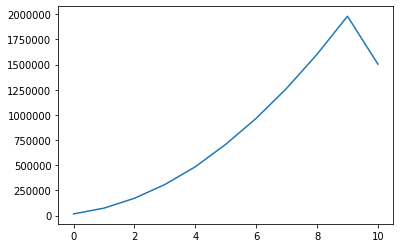

In [51]:
plt.plot(divs)

In [17]:
v = torch.rand(500,2, requires_grad=True)
c = v.clone().detach()
div = divergence(c, 10*v, x_dim=10,y_dim=10)
div.backward()
v.grad

tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.5294,  0.5172],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.2647,  0.0000],
        [ 0.0000, -0.1724],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.5294,  0.5172],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.1513, -0.1478],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.2069],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0

In [419]:
coords = np.loadtxt('projected_output_test.csv').reshape(15, 60000, 2)

In [420]:
c = coords[0]
v = coords[1] - c

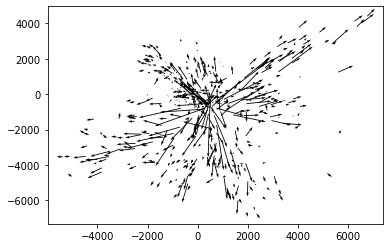

In [50]:
plt.quiver(c[::100,0],c[::100,1],v[::100,0],v[::100,1])

In [428]:
div = divergence(torch.tensor(c), torch.tensor(v), x_dim=50, y_dim=50)

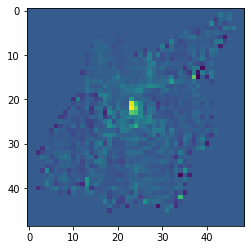

In [430]:
plt.imshow(reversed(div.t()))

In [56]:
divs = []
for i in [10,20,30,40,50,60,70,80,90,100,150,200]:
    divs.append(divergence(torch.tensor(c), torch.tensor(v), x_dim=i, y_dim=i))

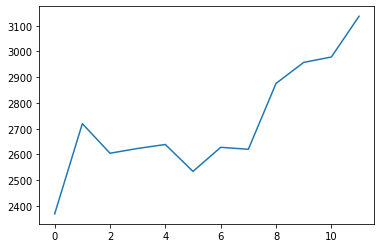

In [57]:
plt.plot(divs)

In [ ]:
#TODO: write test vector fields and check if divergence is correct
#TODO: integrating divergence yields only boundary terms -> introduce non-linearity?
#TODO: 